In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    auc
)
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

**Dataset**

The dataset used in this project is the Credit Card Fraud Detection dataset from Kaggle, which contains transactions made by credit cards in September 2013 by European cardholders. The dataset has 284,807 transactions, out of which 492 are fraudulent. The dataset is highly imbalanced, with the fraudulent transactions accounting for only 0.17% of the total transactions.

**Problem statement**

The goal of this project is to detect anomalous transactions in a dataset of financial transactions. An anomalous transaction is one that deviates significantly from the typical behavior of other transactions in the dataset. We aim to develop a machine learning model that can accurately identify anomalous transactions.

In [2]:
!pip install gdown
!gdown --id 1BRwFlxUPPgq6kjaRmUr7y-R6H-ZKb0Dc -O creditcard.csv
!ls -l creditcard.csv
# Step 1: Load the dataset
data = pd.read_csv('creditcard.csv')

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1BRwFlxUPPgq6kjaRmUr7y-R6H-ZKb0Dc
From (redirected): https://drive.google.com/uc?id=1BRwFlxUPPgq6kjaRmUr7y-R6H-ZKb0Dc&confirm=t&uuid=3e390a1e-a4db-40a5-910c-2ea294ed7fa5
To: /content/creditcard.csv
100% 151M/151M [00:01<00:00, 126MB/s]
-rw-r--r-- 1 root root 150828752 Dec 20 23:40 creditcard.csv


In [3]:
# Step 2: Data Exploration
print("Dataset shape:", data.shape)
print("Class distribution:\n", data['Class'].value_counts())

Dataset shape: (284807, 31)
Class distribution:
 Class
0    284315
1       492
Name: count, dtype: int64


In [4]:
small_subset, _ = train_test_split(
    data, test_size=0.6, random_state=42, stratify=data['Class']
)
data = small_subset
print(small_subset.shape)
#Data Cleaning: remove missing value
data = data.dropna(subset=['Class'])

(113922, 31)


In [5]:
# Step 3: Separate features and target variable
#Optional??: Feature Engineering
# Log Transformation for 'Amount'
data['Log_Amount'] = np.log1p(data['Amount'])
# Temporal Features from 'Time'
data['Hour'] = (data['Time'] // 3600) % 24
data['Day_Night'] = data['Hour'].apply(lambda x: 1 if 6 <= x <= 18 else 0)
X = data.drop(columns=['Class', 'Time', 'Amount'])  # Use engineered features
y = data['Class']

In [6]:
# Step 4: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [7]:
# Step 5: Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Step 6: Handle Imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)
print("Class distribution after SMOTE:\n", y_train_resampled.value_counts())

Class distribution after SMOTE:
 Class
0    79607
1    79607
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


In [8]:
# Step 7: Train the Random Forest Model
print("\nTraining Random Forest Model...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    class_weight='balanced',
    random_state=42
)
rf_model.fit(X_train_resampled, y_train_resampled)



Training Random Forest Model...


RandomForestClassifier(class_weight='balanced', random_state=42)


Confusion Matrix:
 [[34108    10]
 [    6    53]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     34118
           1       0.84      0.90      0.87        59

    accuracy                           1.00     34177
   macro avg       0.92      0.95      0.93     34177
weighted avg       1.00      1.00      1.00     34177

ROC-AUC Score: 0.9995253263598618
Precision-Recall AUC: 0.9421156724999102


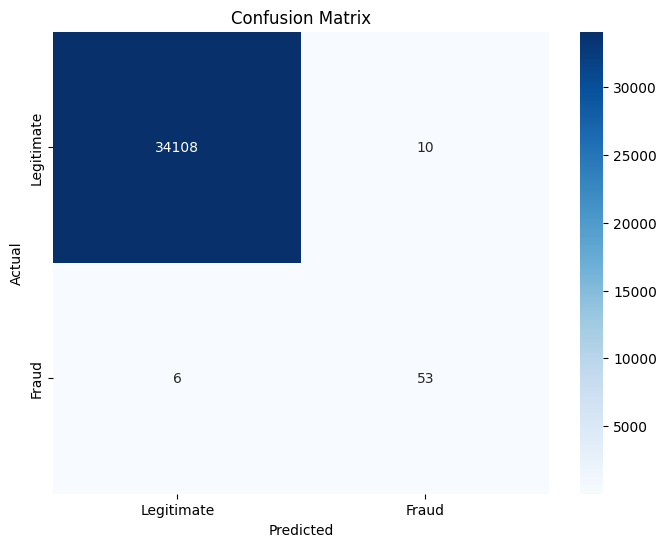

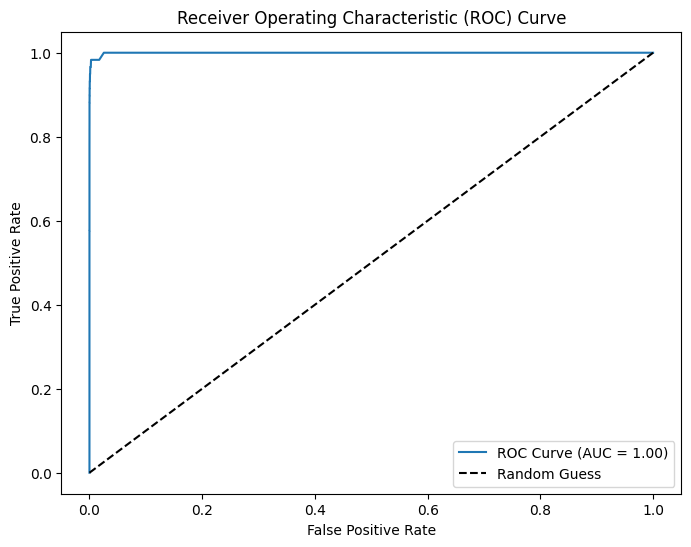

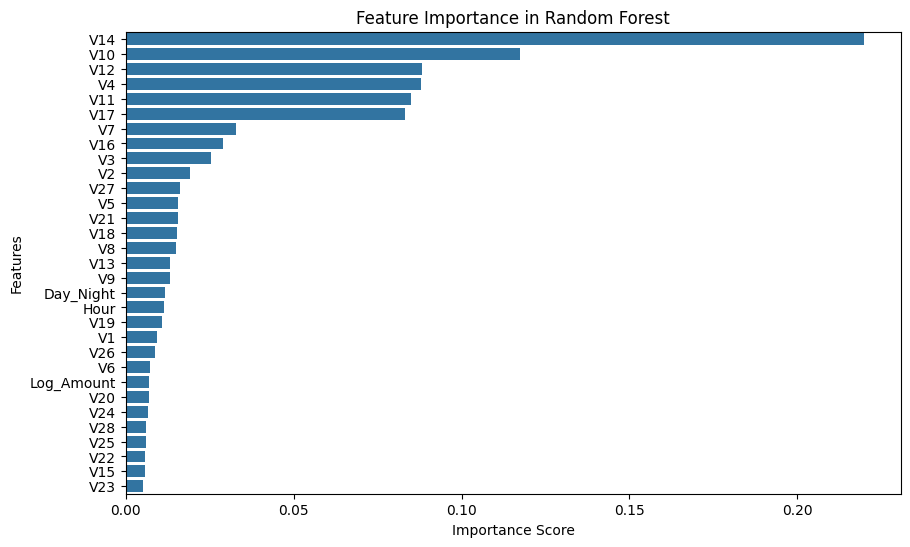

In [9]:
# Predictions
y_pred = rf_model.predict(X_test_scaled)
y_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

# Evaluation Metrics
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC-AUC Score:", roc_auc)

# Precision-Recall AUC
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)
print("Precision-Recall AUC:", pr_auc)

# Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Legitimate", "Fraud"], yticklabels=["Legitimate", "Fraud"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.show()

# Feature Importance
feature_importances = rf_model.feature_importances_
features = X.columns
sorted_indices = np.argsort(feature_importances)[::-1]
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances[sorted_indices], y=features[sorted_indices])
plt.title("Feature Importance in Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()

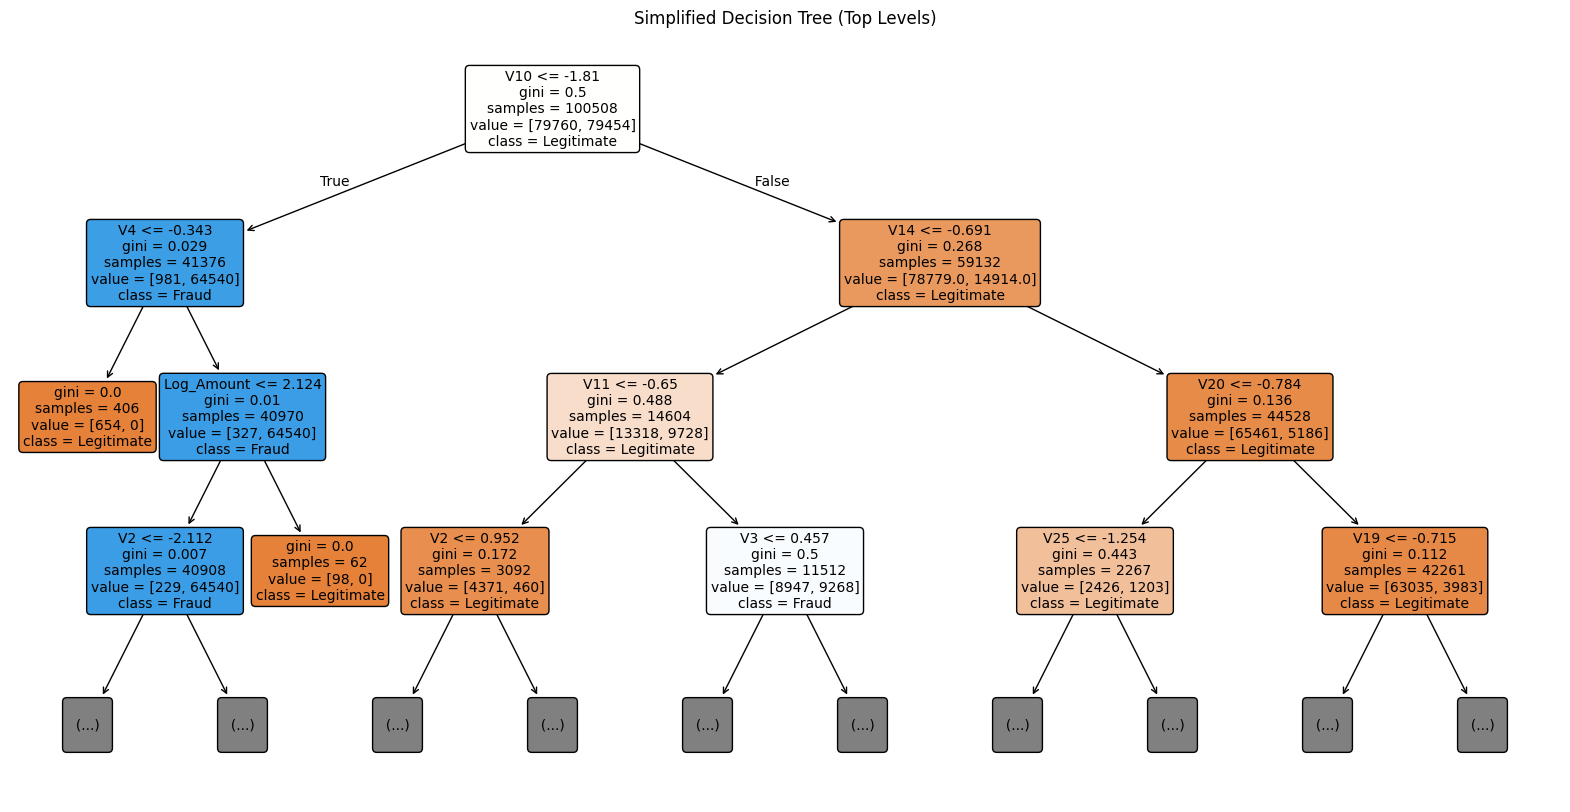

In [10]:
from sklearn.tree import export_graphviz
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt


# Extract one tree from the Random Forest
one_tree = rf_model.estimators_[0]  # Take the first tree

# Plot the tree with limited depth
plt.figure(figsize=(20, 10))
plot_tree(
    one_tree,
    feature_names=X.columns,  # Use feature names for clarity
    class_names=["Legitimate", "Fraud"],  # Class names
    filled=True,  # Color nodes by class
    rounded=True,  # Rounded corners for better visualization
    max_depth=3,  # Limit the depth to 3
    fontsize=10  # Font size
)
plt.title("Simplified Decision Tree (Top Levels)")
plt.show()

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
from imblearn.over_sampling import SMOTE
import numpy as np

# Initialize Stratified K-Fold
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# List to store performance metrics
roc_auc_scores = []
pr_auc_scores = []

# K-Fold Cross-Validation
for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y)):
    print(f"\nFold {fold + 1}")

    # Split data into training and validation sets
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Step 1: Feature Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    # Step 2: Handle Imbalance with SMOTE
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

    # Step 3: Train the Random Forest Model
    rf_model = RandomForestClassifier(
        n_estimators=100,
        max_depth=None,
        class_weight='balanced',
        random_state=42
    )
    rf_model.fit(X_train_resampled, y_train_resampled)

    # Step 4: Make Predictions
    y_pred_proba = rf_model.predict_proba(X_val_scaled)[:, 1]

    # Step 5: Evaluate the Model
    # ROC-AUC Score
    roc_auc = roc_auc_score(y_val, y_pred_proba)
    roc_auc_scores.append(roc_auc)

    # Precision-Recall AUC
    precision, recall, _ = precision_recall_curve(y_val, y_pred_proba)
    pr_auc = auc(recall, precision)
    pr_auc_scores.append(pr_auc)

    print(f"ROC-AUC Score: {roc_auc:.4f}")
    print(f"Precision-Recall AUC: {pr_auc:.4f}")

# Final Results
print("\nCross-Validation Results:")
print(f"Mean ROC-AUC: {np.mean(roc_auc_scores):.4f} ± {np.std(roc_auc_scores):.4f}")
print(f"Mean Precision-Recall AUC: {np.mean(pr_auc_scores):.4f} ± {np.std(pr_auc_scores):.4f}")


Fold 1


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


ROC-AUC Score: 0.9969
Precision-Recall AUC: 0.8936

Fold 2


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


ROC-AUC Score: 0.9542
Precision-Recall AUC: 0.7951

Fold 3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


ROC-AUC Score: 0.9384
Precision-Recall AUC: 0.7315

Fold 4


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


ROC-AUC Score: 0.9657
Precision-Recall AUC: 0.8721

Fold 5


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


ROC-AUC Score: 0.9702
Precision-Recall AUC: 0.9028

Cross-Validation Results:
Mean ROC-AUC: 0.9651 ± 0.0193
Mean Precision-Recall AUC: 0.8390 ± 0.0658



Confusion Matrix (Threshold = 0.3):
 [[34106    12]
 [    0    59]]

Classification Report (Threshold = 0.3):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     34118
           1       0.83      1.00      0.91        59

    accuracy                           1.00     34177
   macro avg       0.92      1.00      0.95     34177
weighted avg       1.00      1.00      1.00     34177



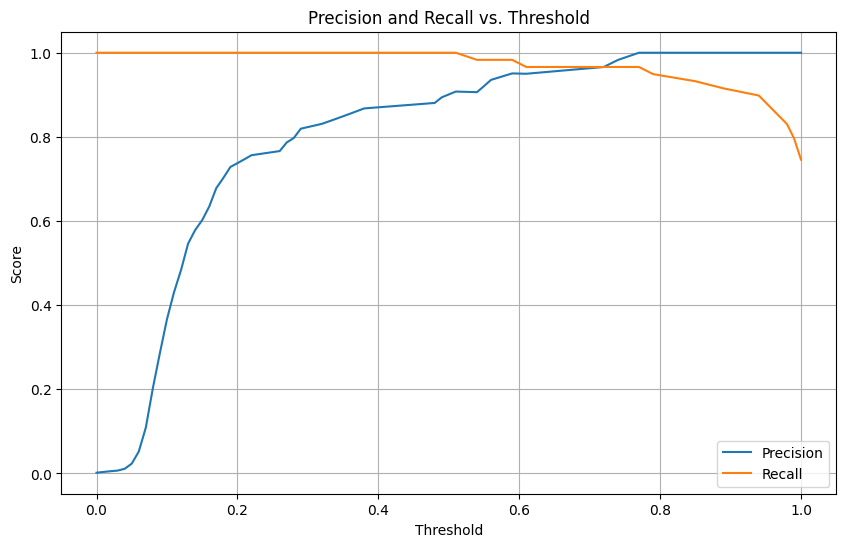

Optimal Threshold (PR Curve): 0.77


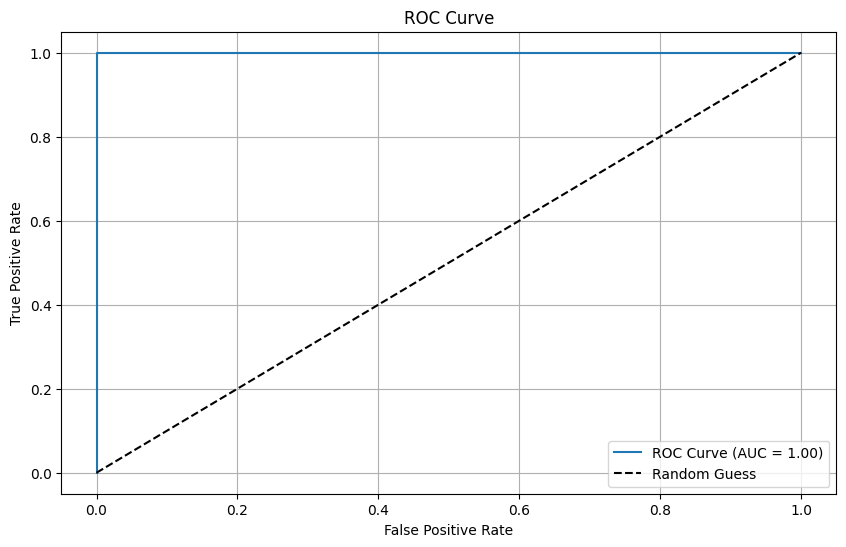

Optimal Threshold (Youden's Index): 0.51

Confusion Matrix (Optimal Threshold = 0.77):
 [[34118     0]
 [    2    57]]

Classification Report (Optimal Threshold = 0.77):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     34118
           1       1.00      0.97      0.98        59

    accuracy                           1.00     34177
   macro avg       1.00      0.98      0.99     34177
weighted avg       1.00      1.00      1.00     34177



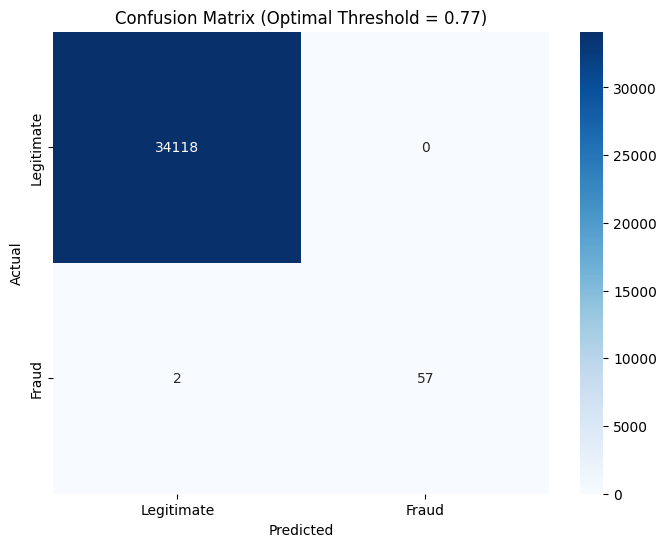

In [12]:
import numpy as np
from sklearn.metrics import precision_recall_curve, roc_curve, classification_report, confusion_matrix, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Get Predicted Probabilities
# Use the already trained Random Forest model to get probabilities for the positive class (fraud)
y_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

# Step 2: Define a Custom Threshold
# Adjust the threshold (e.g., 0.3)
threshold = 0.3
y_pred_adjusted = (y_pred_proba >= threshold).astype(int)

# Step 3: Evaluate Adjusted Predictions
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_adjusted)
print("\nConfusion Matrix (Threshold = 0.3):\n", conf_matrix)

# Classification Report
print("\nClassification Report (Threshold = 0.3):\n", classification_report(y_test, y_pred_adjusted))

# Step 4: Find the Optimal Threshold
# Precision-Recall Curve
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_proba)

plt.figure(figsize=(10, 6))
plt.plot(thresholds_pr, precision[:-1], label="Precision")
plt.plot(thresholds_pr, recall[:-1], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision and Recall vs. Threshold")
plt.legend()
plt.grid()
plt.show()

# Find the threshold where precision and recall are balanced
pr_f1 = 2 * (precision * recall) / (precision + recall)  # F1-Score for each threshold
optimal_idx_pr = np.argmax(pr_f1)
optimal_threshold_pr = thresholds_pr[optimal_idx_pr]
print(f"Optimal Threshold (PR Curve): {optimal_threshold_pr:.2f}")

# Step 5: ROC Curve and Youden’s Index
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc_score(y_test, y_pred_proba):.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

# Find the threshold that maximizes TPR - FPR (Youden's Index)
optimal_idx_roc = np.argmax(tpr - fpr)
optimal_threshold_roc = thresholds_roc[optimal_idx_roc]
print(f"Optimal Threshold (Youden's Index): {optimal_threshold_roc:.2f}")

# Step 6: Apply the Optimal Threshold
# Choose the threshold from PR Curve or ROC Curve analysis
chosen_threshold = optimal_threshold_pr  # or optimal_threshold_roc
y_pred_optimal = (y_pred_proba >= chosen_threshold).astype(int)

# Evaluate Predictions with Optimal Threshold
conf_matrix_optimal = confusion_matrix(y_test, y_pred_optimal)
print(f"\nConfusion Matrix (Optimal Threshold = {chosen_threshold:.2f}):\n", conf_matrix_optimal)

print(f"\nClassification Report (Optimal Threshold = {chosen_threshold:.2f}):\n",
      classification_report(y_test, y_pred_optimal))

# Step 7: Plot Confusion Matrix for Optimal Threshold
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_optimal, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Legitimate", "Fraud"], yticklabels=["Legitimate", "Fraud"])
plt.title(f"Confusion Matrix (Optimal Threshold = {chosen_threshold:.2f})")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()